In [1]:
from duckduckgo_search import ddg_images
from fastdownload import download_url
from fastai.vision.all import Image
from fastai.vision.all import *
from fastcore.all import *
import fire
import os
from time import sleep

from pprint import pprint
from utils import current_dir

In [2]:
def search_images(term, max_images=30):
    """
    Searches duckduckgo for images of a given term and returns a list of urls
    """
    print(f"Searching for '{term}...'")
    return [item['image'] for item in ddg_images(term, max_results=max_images)]


In [3]:
def main(search_term: str, max_images: int = 30):
    urls = search_images(search_term, max_images)
    pprint(urls)
    dest = os.path.join(current_dir('jpgs'), f'{search_term}.jpg')
    download_url(urls[0], dest, show_progress=False)
    image = Image.open(dest)
    return image.to_thumb(256,256)

Searching for 'forest photos...'


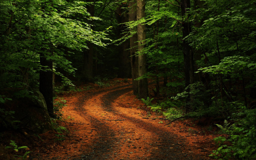

In [5]:
download_url(search_images('forest photos', max_images=2)[1], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [6]:
import os
from time import sleep

searches = 'forest','bird'
path = Path('bird_or_not')

for o in searches:
    dest = path/o
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(0.5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(0.5)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(0.5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo...'
Searching for 'forest sun photo...'
Searching for 'forest shade photo...'
Searching for 'bird photo...'
Searching for 'bird sun photo...'
Searching for 'bird shade photo...'


In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

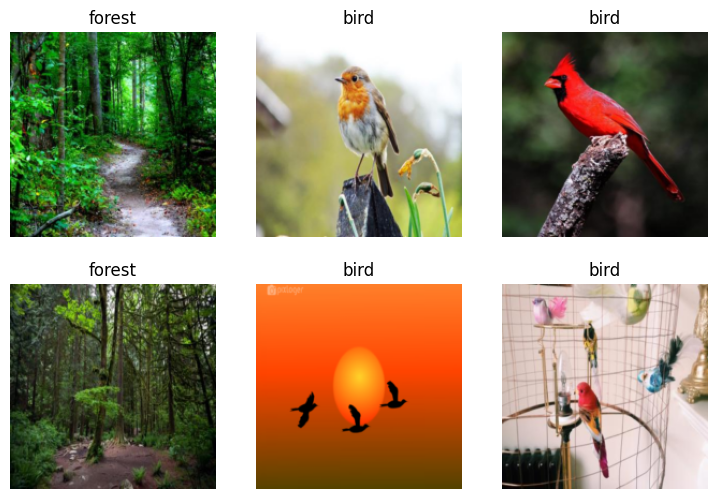

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [17]:
from fastai.vision.all import *
from fastai.callback.progress import ProgressCallback

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn = learn.add_cb(ProgressCallback())
learn.fine_tune(3)


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

In [19]:
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: forest.
Probability it's a bird: 0.0000
